In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns
sns.set()
from tqdm import tqdm

import itertools
from scipy import stats
from math import log10, floor

import phenalyze as ph

# Lectura de datos

In [72]:
k_r_list = np.linspace(1,3,10)
b_list = np.linspace(1,3,10)
h_list = np.linspace(1,4,10)

In [73]:
datalist = []

for h_i in h_list:
    for k_r in k_r_list:
        for b_i in b_list:
            df = pd.read_csv(f"Data_RangoParcial/Activadores/RuidoIntrinseco/ActInt_h{h_i:.1f}_kr{k_r:.1f}_b{b_i:.1f}.csv", header=0, index_col=0)
            df.insert(0, "h", [h_i, h_i])
            df.insert(1, "kr", [k_r, k_r])
            df.insert(2, "Beta", [b_i, b_i])
            datalist.append(df)

tint_data = pd.concat(datalist)
tint_data.columns = ['h', 'kr', 'Beta', 'RNA 1', 'Protein 1', 'RNA 2', 'Protein 2', 'RNA 3', 'Protein 3']
display(tint_data)

,h,kr,Beta,RNA 1,Protein 1,RNA 2,Protein 2,RNA 3,Protein 3
Mean,1.0,1.0,1.000000,4.355627,4219.884147,1.877175,1818.982920,2.674633,2595.485668
CV2,1.0,1.0,1.000000,0.229451,0.031389,0.541544,0.078467,0.415254,0.076069
Mean,1.0,1.0,1.222222,4.372774,4236.822858,2.303026,2230.811449,3.106279,3010.879310
CV2,1.0,1.0,1.222222,0.229475,0.031630,0.444610,0.065407,0.352022,0.061942
Mean,1.0,1.0,1.444444,4.365185,4229.280240,2.716578,2633.559073,3.486861,3386.125397
...,...,...,...,...,...,...,...,...,...
CV2,4.0,3.0,2.555556,0.076334,0.010447,0.093780,0.012994,0.101189,0.014363
Mean,4.0,3.0,2.777778,13.095932,12688.404242,11.658871,11303.085035,10.262542,9949.761918
CV2,4.0,3.0,2.777778,0.076131,0.010371,0.085950,0.011851,0.098323,0.013825
Mean,4.0,3.0,3.000000,13.077385,12677.721248,12.599923,12218.552151,10.432108,10113.535299


In [74]:
datalist = []

for h_i in h_list:
    for k_r in k_r_list:
        for b_i in b_list:
            df = pd.read_csv(f"Data_RangoParcial/Activadores/RuidoNeto/ActGlob_h{h_i:.1f}_kr{k_r:.1f}_b{b_i:.1f}.csv", header=0, index_col=0)
            df = df.T
            df.insert(0, "h", [h_i, h_i])
            df.insert(1, "kr", [k_r, k_r])
            df.insert(2, "Beta", [b_i, b_i])
            datalist.append(df)

tnet_data = pd.concat(datalist)
tnet_data.columns = ['h', 'kr', 'Beta', 'RNA 1', 'Protein 1', 'RNA 2', 'Protein 2', 'RNA 3', 'Protein 3']
display(tnet_data)

,h,kr,Beta,RNA 1,Protein 1,RNA 2,Protein 2,RNA 3,Protein 3
Mean,1.0,1.0,1.000000,4.362247,4225.386915,1.899171,1840.190390,2.737285,2652.887150
CV2,1.0,1.0,1.000000,0.282932,0.061421,0.630421,0.138382,0.543079,0.169048
Mean,1.0,1.0,1.222222,4.363502,4230.420500,2.320890,2247.972416,3.169097,3068.523500
CV2,1.0,1.0,1.222222,0.283374,0.061648,0.534511,0.125462,0.479981,0.154365
Mean,1.0,1.0,1.444444,4.365927,4229.562584,2.742125,2657.169478,3.549201,3444.157836
...,...,...,...,...,...,...,...,...,...
CV2,4.0,3.0,2.555556,0.130058,0.040358,0.158789,0.051375,0.188304,0.068414
Mean,4.0,3.0,2.777778,13.095900,12687.202583,11.580288,11233.460218,10.093776,9802.217596
CV2,4.0,3.0,2.777778,0.130507,0.040580,0.151398,0.050286,0.176864,0.061502
Mean,4.0,3.0,3.000000,13.090338,12688.433344,12.514029,12140.520759,10.301040,10002.311231


### Organización de los datos

In [75]:
tres_int = tint_data.loc["CV2"]
tres_net = tnet_data.loc["CV2"]

tres_efc = tres_net.copy()
tres_efc["RNA 3"] = tres_net["RNA 3"] - tres_int["RNA 3"]
tres_efc["Protein 3"] = tres_net["Protein 3"] - tres_int["Protein 3"]

# Seed Tuning

In [76]:
def round_to_n(x, n):
  return round(x, -(int(floor(log10(abs(x))))-n+1))

round_to_n = np.vectorize(round_to_n)

In [77]:
def seed_explorer(data, h_list, model, params_space, bounds):
    all_params = []
    all_errs = []
    all_R2 = []

    all_seeds = list(itertools.product(*params_space))
    for seed in tqdm(all_seeds):
        params, err, Rsquared = ph.compute_3dfit(data, h_list, model, seed=10*[seed], lims=10*[bounds], max_ef=100000000)
        all_params.append(params)
        all_errs.append(err)
        all_R2.append(Rsquared)

    return np.array(all_seeds), np.array(all_params), np.array(all_errs), np.array(all_R2)



def seed_explorer(data, h_list, model, params_space, bounds):
    all_params = []
    all_errs = []
    all_R2 = []

    all_seeds = list(itertools.product(*params_space))
    for seed in tqdm(all_seeds):
        params, err, Rsquared = ph.compute_3dfit(data, h_list, model, seed=10*[seed], lims=10*[bounds], max_ef=100000000)
        all_params.append(params)
        all_errs.append(err)
        all_R2.append(Rsquared)

    return np.array(all_seeds), np.array(all_params), np.array(all_errs), np.array(all_R2)


def seed_estimator(seeds, params, errs, R2s, n=None, R2_precision=6, params_SF=4):
    R2s = R2s.mean(axis=1)

    ii_kill = np.argwhere(np.isnan(R2s))
    print(f"{len(ii_kill)} de {len(R2s)} semillas resultaron en NaNs")

    R2s = np.delete(R2s, ii_kill, axis=0)
    seeds = np.delete(seeds, ii_kill, axis=0)
    params = np.delete(params, ii_kill, axis=0)
    errs = np.delete(errs, ii_kill, axis=0)

    ii_max = np.argsort(R2s, axis=0)[::-1]
    
    R2max = np.sort(R2s,axis=0)[::-1][0]
    i = 0
    R2i = np.sort(R2s,axis=0)[::-1][i]
    params = params.mean(axis=1)
    while R2i.round(R2_precision)==R2max.round(R2_precision) and np.all(round_to_n(params[ii_max[i],:], params_SF)==round_to_n(params[ii_max[0],:], params_SF)):
        R2i = np.sort(R2s,axis=0)[::-1][i]
        i+=1
    n_sug = i
    print(f"n sugerido: {n_sug} de {len(R2s)}")

    if n is None:
        n = n_sug

    best_seeds = seeds[ii_max[:n]]
    errs = errs.mean(axis=1)
    best_seeds_err = errs[ii_max[:n]]

    if np.isinf(best_seeds_err).any():
        print(f"Hay {np.isinf(best_seeds_err).sum()} errores infinitos")
    else:
        print(f"No hay errores infinitos en los {n} mejores")
        
    tuned_seed, _ = stats.mode(best_seeds, axis=0, keepdims=False)

    return tuned_seed

In [78]:
def PlotOptmizedParams(ParamsTensor, R2List, shape, labels, title, fig_size=(12,8)):
    fig = plt.figure(figsize=fig_size)
    export_data = []
    for i in range(np.shape(ParamsTensor)[1]):
        ax = fig.add_subplot(shape[0],shape[1],i+1)
        ax.plot(ParamsTensor[:,i], marker='.')
        ax.set_ylabel(fr"Parámetro ${labels[i]}$ del modelo")
        ax.set_xlabel(r"Coeficiente de Hill ($h$)")
        export_data.append([ParamsTensor[:,i], ax.get_ylim()])
    ax = fig.add_subplot(shape[0],shape[1],i+2)
    ax.plot(R2List, marker=".")
    ax.set_ylabel(r"$R^2$")
    ax.set_xlabel(r"Coeficiente de Hill ($h$)")
    ax.set_ylim(0,1.1)

    print(export_data)
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig("GraficasParaGuardar/MalMuestreo/"+title.replace(' ','').replace('$','').replace('\e','e').replace('\n','')+".png")

# Análisis

### Ruido intrínseco

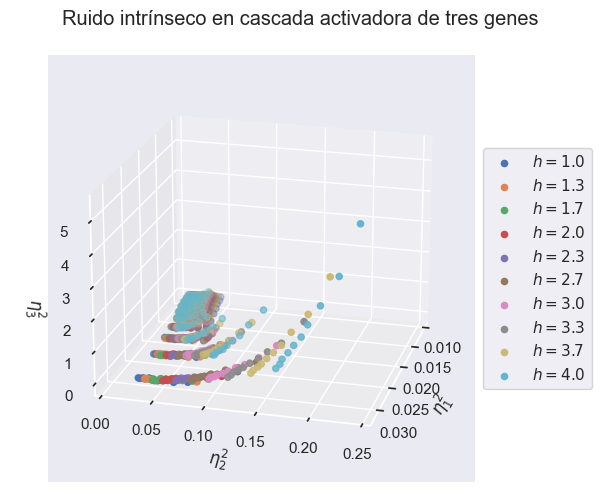

In [79]:
ph.plot_3ddata_all_h(tres_int, h_list, fig_size=(6,5), title="Ruido intrínseco en cascada activadora de tres genes", view_init=[20,15,0])
plt.savefig("GraficasDocumento/DataIntrinsecoTresActivadores.png")

In [80]:
def model(data, A, b, C, d, K):
    x, y = data
    return A*np.exp(b*x) + C*np.exp(d*y) + K

n_params = 5
space_int = n_params*[[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]]
bounds_int = ((n_params-1)*[-np.inf]+[0.0], n_params*[np.inf])

# seeds_int, all_params_int, all_errs_int, all_R2_int = seed_explorer(tres_int, h_list, model, space_int, bounds_int)
# np.savez("SeedExplr2.0_IntrinsecoTresActivadores", seeds=seeds_int, params=all_params_int, errs=all_errs_int, R2=all_R2_int)

In [81]:
exploration_data = np.load("SeedExplr2.0_IntrinsecoTresActivadores.npz")
seeds_int, all_params_int, all_errs_int, all_R2_int = exploration_data["seeds"], exploration_data["params"], exploration_data["errs"], exploration_data["R2"]

In [82]:
def_seed_int = seed_estimator(seeds_int, all_params_int, all_errs_int, all_R2_int, params_SF=0)
def_seed_int

0 de 16807 semillas resultaron en NaNs
n sugerido: 1 de 16807
No hay errores infinitos en los 1 mejores


array([1.e-01, 1.e-01, 1.e-01, 1.e+02, 1.e-02])

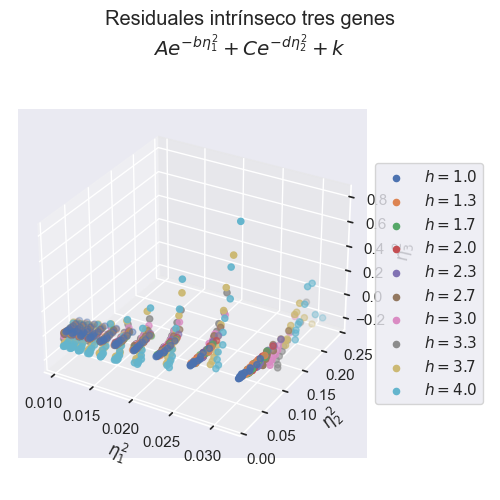

In [83]:
params, err, Rsquared = ph.compute_3dfit(tres_int, h_list, model, seed=10*[def_seed_int], lims=10*[bounds_int], max_ef=100000000)
# print(Rsquared)

ph.plot_3dresiduals_all_h(tres_int, h_list, model, params, title="Residuales intrínseco tres genes"+"\n"+r"$A e^{-b \eta_1^2} + C e^{-d \eta_2^2} + k$", fig_size=(5,5))
# print(np.array(params).T)

TresIntParams = np.array(params)
TresIntR2 = np.array(Rsquared)

[[array([-1.49213800e-01, -1.33362377e-01, -1.85456130e-01, -2.66713384e-01,
       -3.81674991e-01, -4.50300360e-01, -4.11004799e-01, -3.61321370e-01,
       -2.54601426e-11, -9.77796545e-12]), (-0.4728153779164768, 0.022515017985779123)], [array([  1.00980671,   3.48210666,   6.32453787,   9.20417519,
        11.92652544,  16.30401643,  23.91176022,  31.66900732,
       745.60196795, 795.57035051]), (-38.71822047819315, 835.2983776982835)], [array([0.16046385, 0.14064822, 0.19078517, 0.27560407, 0.40399075,
       0.50151031, 0.50524738, 0.49999949, 0.07739496, 0.09697259]), (0.056002335639942113, 0.526639997502582)], [array([ 4.59985911,  7.87998638,  8.72546786,  8.68005655,  8.17915746,
        8.32776183,  9.23403149,  9.76785585, 18.72427068, 17.2629697 ]), (3.893638534514957, 19.430491253335315)], [array([7.95944172e-07, 2.16043860e-19, 1.42877365e-14, 9.67697060e-11,
       1.93975448e-20, 7.26955266e-16, 3.36017175e-17, 1.64941663e-16,
       4.29088338e-37, 2.03015983e-36]),

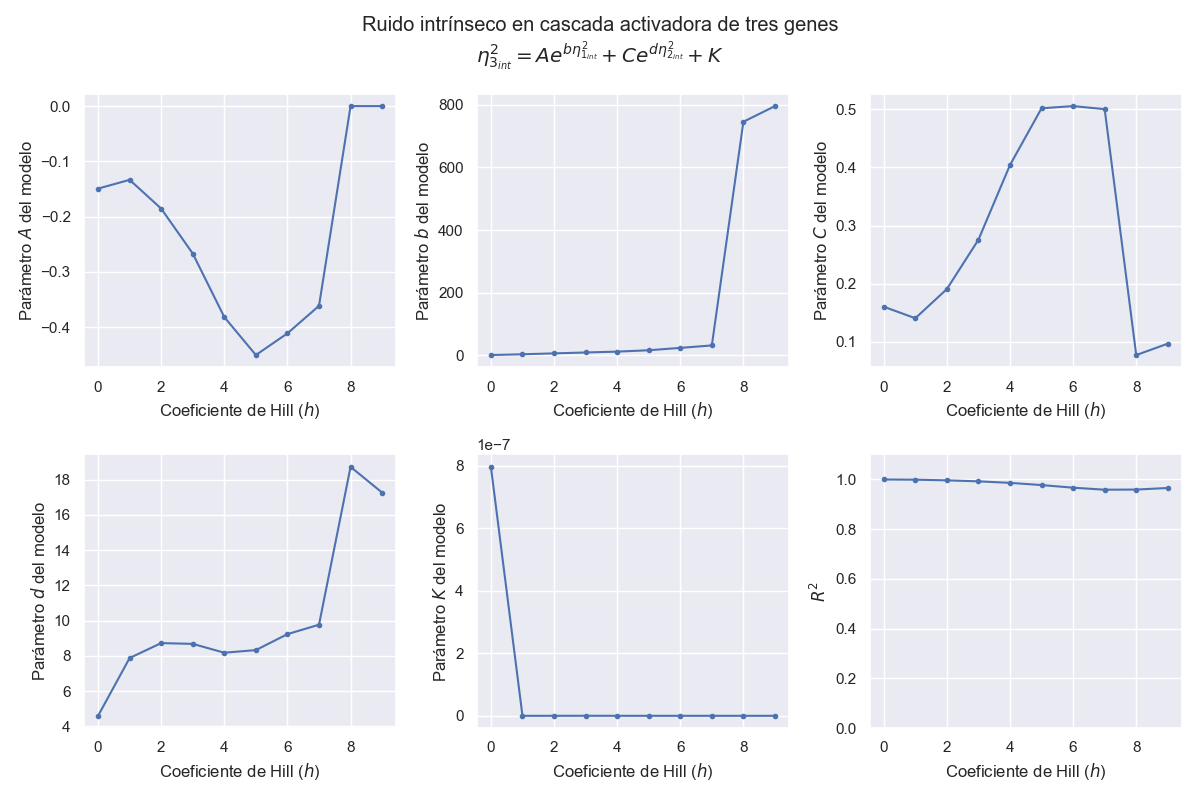

In [84]:
labels = ["A", "b", "C", "d", "K"]
PlotOptmizedParams(TresIntParams, TresIntR2, (2,3), labels, "Ruido intrínseco en cascada activadora de tres genes"+"\n"+r"$\eta_{3_{int}}^2 = Ae^{b\eta_{1_{int}}^2}+Ce^{d\eta_{2_{int}}^2}+K$")

### Ruido Global

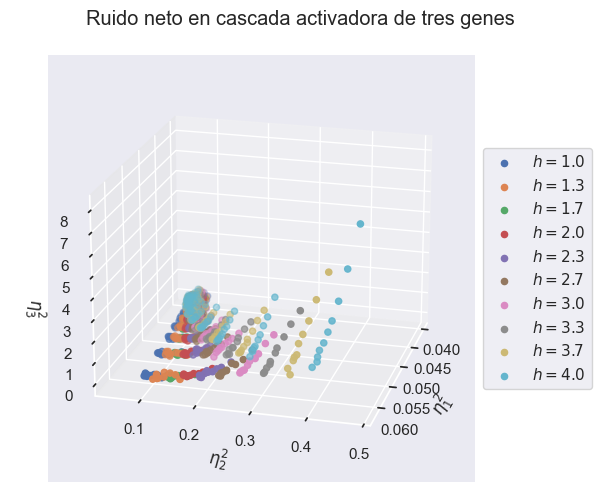

In [85]:
ph.plot_3ddata_all_h(tres_net, h_list, fig_size=(6,5), title="Ruido neto en cascada activadora de tres genes", view_init=[20,15,0])

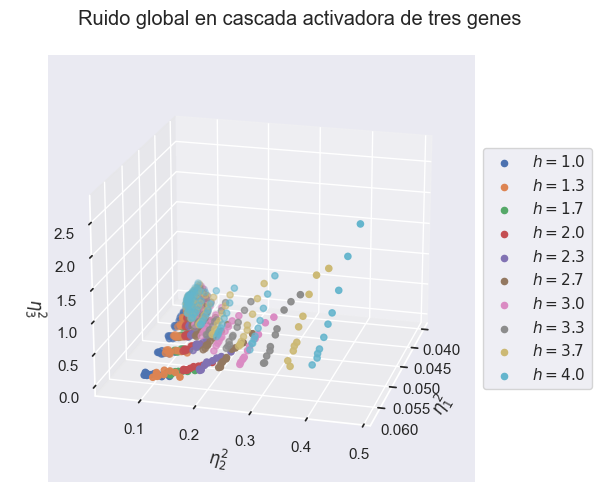

In [86]:
ph.plot_3ddata_all_h(tres_efc, h_list, fig_size=(6,5), title="Ruido global en cascada activadora de tres genes", view_init=[20,15,0])

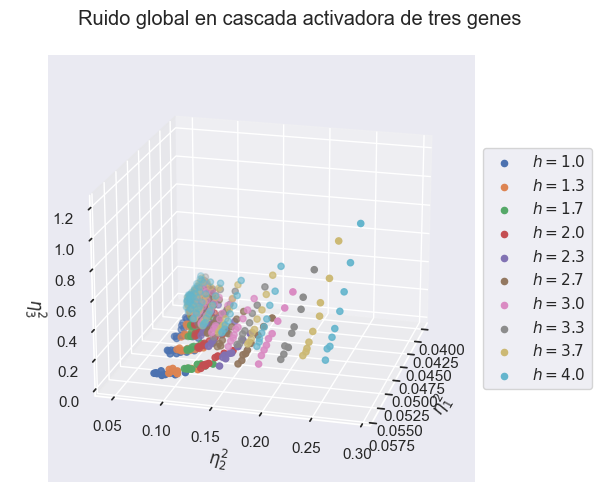

In [87]:
ph.plot_3ddata_all_h(tres_efc[(tres_efc["kr"]>1) & (tres_efc["Beta"]>1)], h_list, fig_size=(6,5), title="Ruido global en cascada activadora de tres genes", view_init=[20,15,0])
plt.savefig("GraficasDocumento/DataGlobalTresActivadores.png")

In [88]:
def model(data, A, b, C, d, K):
    x, y = data
    return A*(x**b) + C*(y**d) + K

n_params = 5

space_net = n_params*[[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]]

bounds_net = ((n_params-1)*[-np.inf]+[0.0], n_params*[np.inf])

# seeds_net, all_params_net, all_errs_net, all_R2_net = seed_explorer(tres_efc, h_list, model, space_net, bounds_net)
# np.savez("SeedExplr2.0_GlobalTresActivadores", seeds=seeds_net, params=all_params_net, errs=all_errs_net, R2=all_R2_net)

In [89]:
exploration_data = np.load("SeedExplr2.0_GlobalTresActivadores.npz")
seeds_net, all_params_net, all_errs_net, all_R2_net = exploration_data["seeds"], exploration_data["params"], exploration_data["errs"], exploration_data["R2"]

In [90]:
def_seed_net = seed_estimator(seeds_net, all_params_net, all_errs_net, all_R2_net, params_SF=3)
def_seed_net

0 de 16807 semillas resultaron en NaNs
n sugerido: 1 de 16807
No hay errores infinitos en los 1 mejores


array([0.001, 0.1  , 0.1  , 0.001, 1.   ])

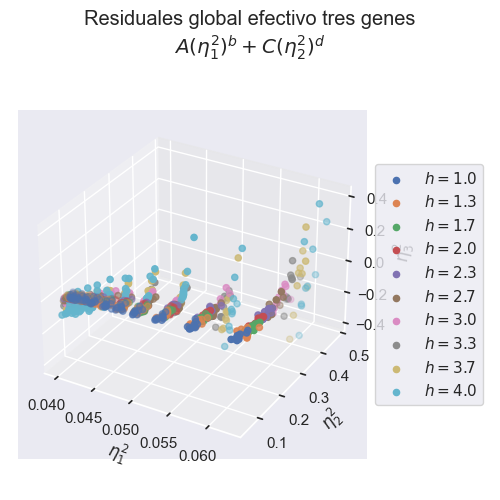

In [91]:
params, err, Rsquared = ph.compute_3dfit(tres_efc, h_list, model, seed=10*[def_seed_net], lims=10*[bounds_net], max_ef=100000000)
# print(Rsquared)

ph.plot_3dresiduals_all_h(tres_efc, h_list, model, params, title="Residuales global efectivo tres genes"+"\n"+r"$A(\eta_1^2)^b + C(\eta_2^2)^d$", fig_size=(5,5))
# print(np.array(params).T)

TresGlobParams = np.array(params)
TresGlobR2 = np.array(Rsquared)

In [92]:
# tup1 = [0,0,0,1,1]
# tup2 = [0,2,4,1,3]

# fig = plt.figure(figsize=(12,8))
# for i in range(np.shape(TresGlobParams)[1]):
#     ax = plt.subplot2grid((2,6), (tup1[i],tup2[i]), colspan=2)
#     ax.plot(TresGlobParams[:,i], marker='.')
#     ax.set_ylabel(fr"Parámetro ${labels[i]}$ del modelo")
#     ax.set_xlabel(r"Coeficiente de Hill ($h$)")
# plt.suptitle("Ruido global en cascada activadora de tres genes"+"\n"+r"$\eta_{3_g}^2=A{\eta_{1_g}^2}^{b}+C{\eta_{2_g}^2}^{d}+K$")
# plt.tight_layout()

[[array([ 2.17405941e-06, -7.28226258e+01, -2.56829944e+00, -1.55104094e+01,
       -9.25687175e+02, -2.57742692e+04, -1.75670878e+06, -9.78012285e+06,
       -7.70898627e+07, -3.88796521e+11]), (-408236347554.5302, 19439826074.025253)], [array([-2.58523540e+00,  1.05221623e-03,  1.53567633e-01,  1.11591155e+00,
        2.48873894e+00,  3.50705196e+00,  4.86830982e+00,  5.37469790e+00,
        5.99713315e+00,  8.87756528e+00]), (-3.1583754304931597, 9.45070531730005)], [array([-7.2859632 ,  0.8352281 ,  1.71328836,  3.14324225,  6.27991151,
       10.26067844, 16.41261907, 16.73838634, 20.13955601, 35.73541725]), (-9.437032223377727, 37.886486276004476)], [array([-0.00751155,  0.47058292,  0.66764889,  0.82393538,  1.08197345,
        1.21428532,  1.42250658,  1.34467437,  1.40671481,  1.7792271 ]), (-0.0968484832524257, 1.8685640318042949)], [array([ 7.48642615, 72.41187773,  1.36649059,  0.18569923,  0.08951973,
        0.08950822,  0.10930435,  0.07672978,  0.14316332,  0.12363261])

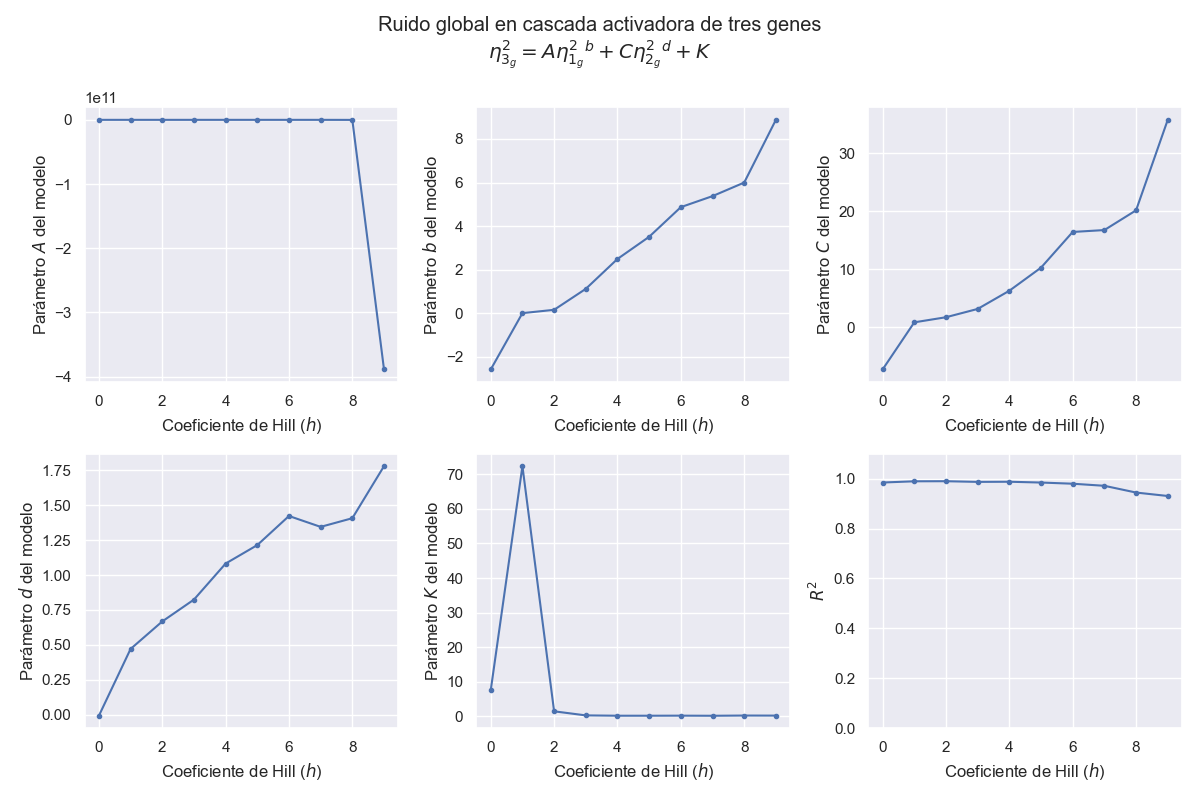

In [93]:
labels = ["A", "b", "C", "d", "K"]
PlotOptmizedParams(TresGlobParams, TresGlobR2, (2,3), labels, "Ruido global en cascada activadora de tres genes"+"\n"+r"$\eta_{3_g}^2=A{\eta_{1_g}^2}^{b}+C{\eta_{2_g}^2}^{d}+K$")

# Import

In [131]:
bootstrap_data = np.load("Bootstrap_IntrinsecoTresActivadores.npz")
ParamsTensorTresInt, ErrTensorTresInt, R2TensorTresInt = bootstrap_data["params"], bootstrap_data["errs"], bootstrap_data["R2"]

bootstrap_data = np.load("Bootstrap_GlobalTresActivadores.npz")
ParamsTensorTresEfc, ErrTensorTresEfc, R2TensorTresEfc = bootstrap_data["params"], bootstrap_data["errs"], bootstrap_data["R2"]

In [132]:
def define_lims(SimpleTensor, ParamsTensor):
    lims = []
    fig = plt.figure()
    for i in range(np.shape(SimpleTensor)[1]):
        ax1 = fig.add_subplot(121)
        ax1.plot(SimpleTensor[:,i], marker='.')

        ax2 = fig.add_subplot(122)
        ax2.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i] for j in range(len(h_list))]))

        lims.append((min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1])))
    plt.close()
    return lims


def weited_mean(x,σ2):
    w = 1/(σ2+1)
    sum_mean = np.sum(w*x)
    sum_var = np.sum(w)
    return [sum_mean/sum_var, 1/sum_var]

In [133]:
tup1 = [0,0,0,1,1]
tup2 = [0,2,4,1,3]

def plot_bootstrap(SimpleTensor, ParamsTensor, ErrTensor, labels, fig_size=(12,8), title="Figura sin título"):
    lims = define_lims(SimpleTensor, ParamsTensor)
    fig = plt.figure(figsize=fig_size)
    for i_plot in range(len(labels)):
        means_list = []
        stds_list = []
    
        # ax = fig.add_subplot(1, len(labels), i_plot+1)
        ax = plt.subplot2grid((2,6), (tup1[i_plot],tup2[i_plot]), colspan=2)
        for i_h in range(len(h_list)):
            ii_ErrorFinito = np.isfinite(ErrTensor[i_h][:,i_plot])
            means, stds = weited_mean(ParamsTensor[i_h][:,i_plot][ii_ErrorFinito], ErrTensor[i_h][:,i_plot][ii_ErrorFinito])
            means_list.append(means)
            stds_list.append(1.96*stds)

        im = ax.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i_plot] for j in range(len(h_list))]), c=np.concatenate([1/ErrTensor[j][:,i_plot] for j in range(len(h_list))]), s=1, cmap="viridis_r")
        plt.colorbar(im, ax=ax, label="Peso")
        
        ax.errorbar(x=h_list, y=np.array(means_list), yerr=1.96*np.array(stds_list), ecolor='black', alpha=0.5, capsize=5, fmt=" ")


        ax.set_ylabel(fr"Parámetro ${labels[i_plot]}$ del modelo")#, fontsize=15)
        ax.set_xlabel(r"Coeficiente de Hill ($h$)")#, fontsize=15)
        ax.set_ylim(lims[i_plot])

        if i_plot==1:
            ax.set_title("Después del remuestreo")

    # plt.suptitle(title)#, fontsize=20)
    plt.tight_layout()
    name = title.split("\n")[0].replace(" ","")
    plt.savefig(f"GraficasParaGuardar/EfectoBootstrap/DESPUES{name}.png")


def plot_prebootstrap(SimpleTensor, ParamsTensor, ErrTensor, labels, fig_size=(12,8), title="Figura sin título"):
    lims = define_lims(SimpleTensor, ParamsTensor)
    fig = plt.figure(figsize=fig_size)
    for i in range(np.shape(SimpleTensor)[1]):
        # ax = fig.add_subplot(1, len(labels), i+1)
        ax = plt.subplot2grid((2,6), (tup1[i],tup2[i]), colspan=2)

        ax.plot(SimpleTensor[:,i], marker='.')

        ax.set_ylim(lims[i])
        ax.set_ylabel(fr"Parámetro ${labels[i]}$ del modelo")#, fontsize=15)
        ax.set_xlabel(r"Coeficiente de Hill ($h$)")#, fontsize=15)

        if i==1:
            ax.set_title("Antes del remuestreo")

    plt.suptitle(title)#, fontsize=20)
    plt.tight_layout()
    name = title.split("\n")[0].replace(" ","")
    plt.savefig(f"GraficasParaGuardar/EfectoBootstrap/ANTES_{name}.png")


C:\Users\aleja\AppData\Local\Temp\ipykernel_4900\623865020.py:19: RuntimeWarning: divide by zero encountered in divide
  im = ax.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i_plot] for j in range(len(h_list))]), c=np.concatenate([1/ErrTensor[j][:,i_plot] for j in range(len(h_list))]), s=1, cmap="viridis_r")


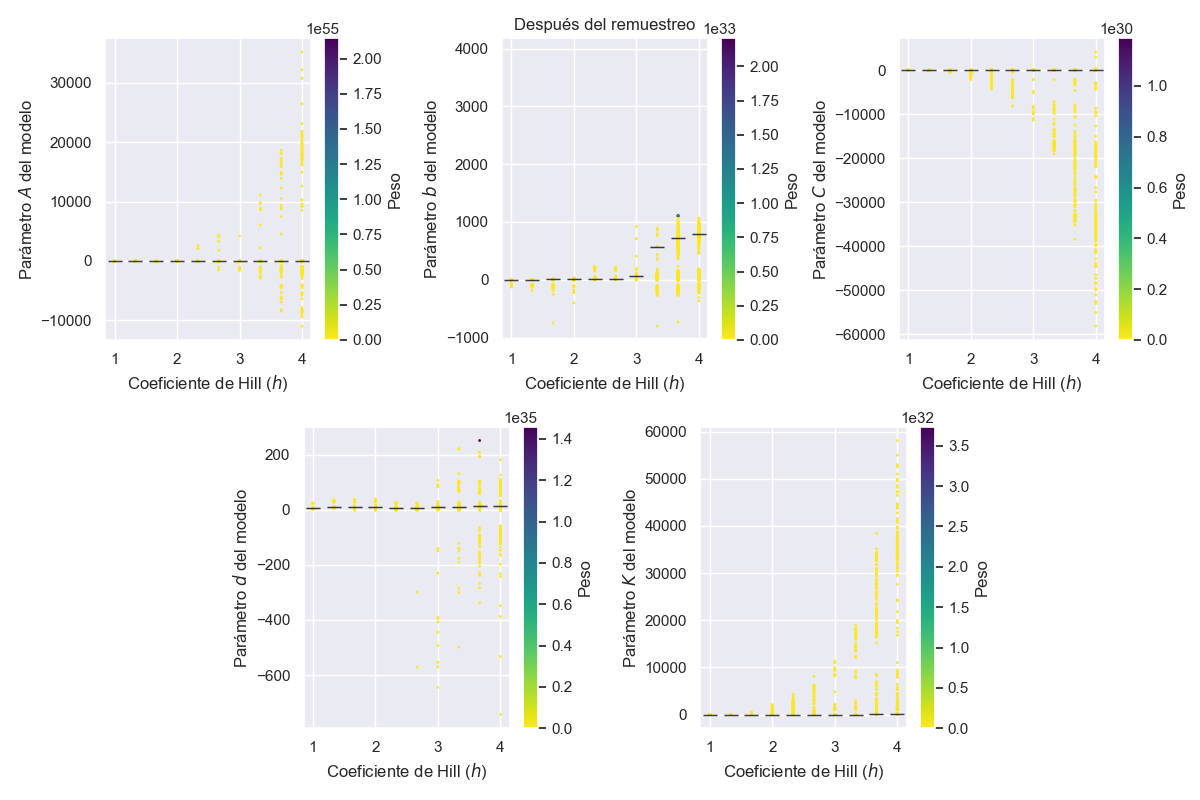

In [134]:
labels = ["A", "b", "C", "d", "K"]
plot_bootstrap(TresIntParams, ParamsTensorTresInt, ErrTensorTresInt, labels, title="Ruido intrínseco en cascada activadora de tres genes"+"\n"+r"$\eta_{3_{int}}^2 = Ae^{b\eta_{1_{int}}^2}+Ce^{d\eta_{2_{int}}^2}+K$")

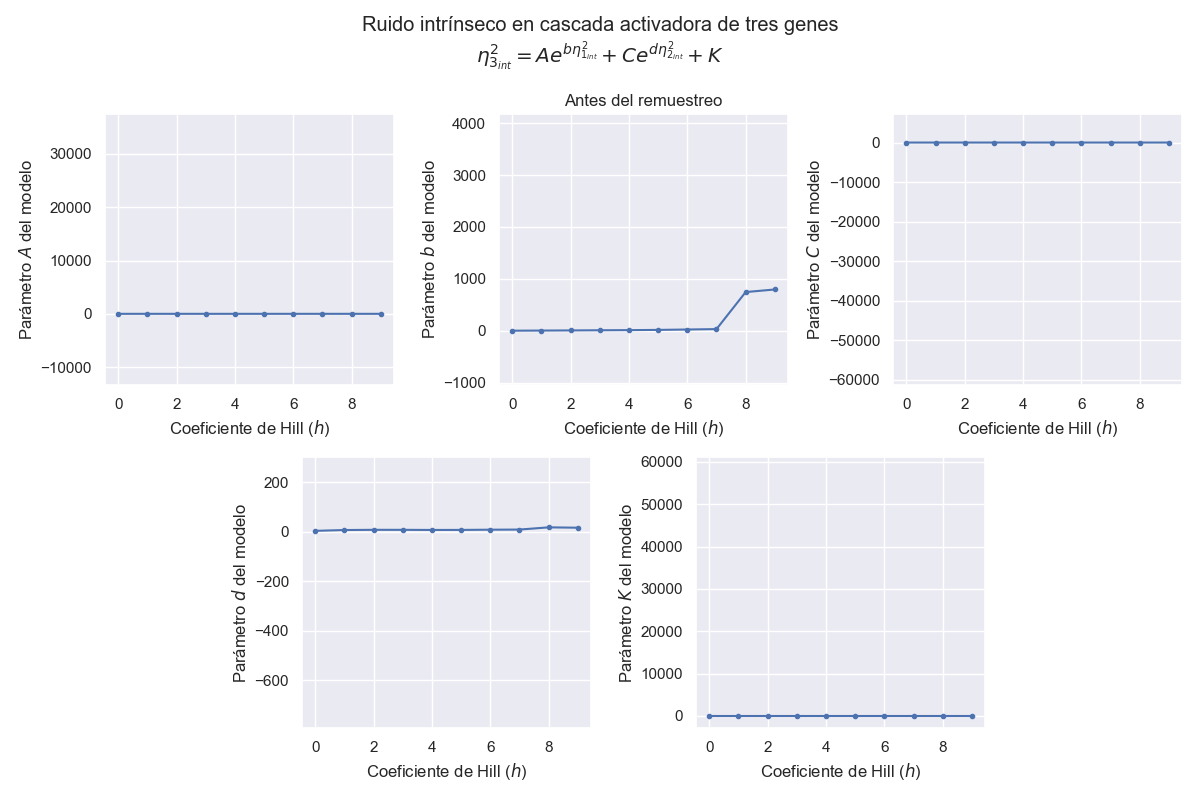

In [135]:
labels = ["A", "b", "C", "d", "K"]
plot_prebootstrap(TresIntParams, ParamsTensorTresInt, ErrTensorTresInt, labels, title="Ruido intrínseco en cascada activadora de tres genes"+"\n"+r"$\eta_{3_{int}}^2 = Ae^{b\eta_{1_{int}}^2}+Ce^{d\eta_{2_{int}}^2}+K$")

C:\Users\aleja\AppData\Local\Temp\ipykernel_4900\623865020.py:19: RuntimeWarning: divide by zero encountered in divide
  im = ax.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i_plot] for j in range(len(h_list))]), c=np.concatenate([1/ErrTensor[j][:,i_plot] for j in range(len(h_list))]), s=1, cmap="viridis_r")


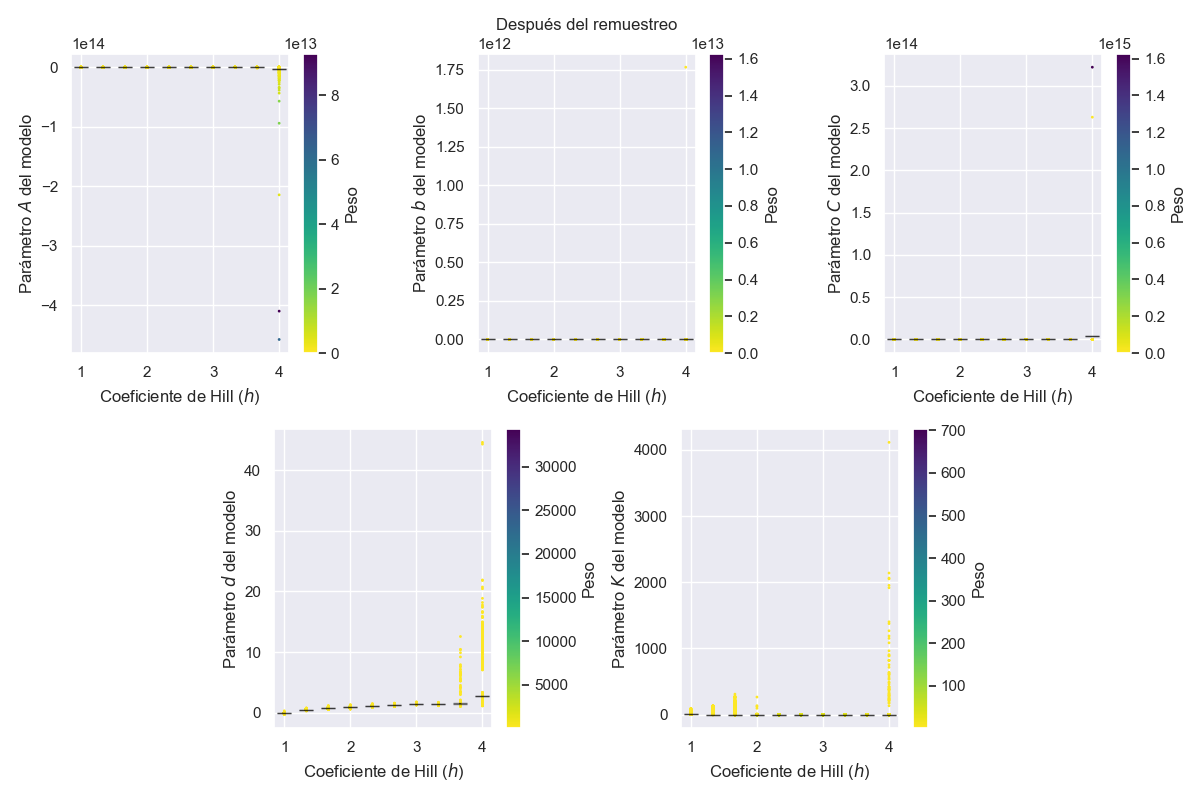

No such comm: 607aae58bd6049ce9769d1fb245a3906
No such comm: 607aae58bd6049ce9769d1fb245a3906
No such comm: 607aae58bd6049ce9769d1fb245a3906
No such comm: 607aae58bd6049ce9769d1fb245a3906


In [ ]:
labels = ["A", "b", "C", "d", "K"]
plot_bootstrap(TresGlobParams, ParamsTensorTresEfc, ErrTensorTresEfc, labels, title="Ruido global en cascada activadora de tres genes"+"\n"+r"$\eta_{3_g}^2=A{\eta_{1_g}^2}^{b}+C{\eta_{2_g}^2}^{d}+K$")

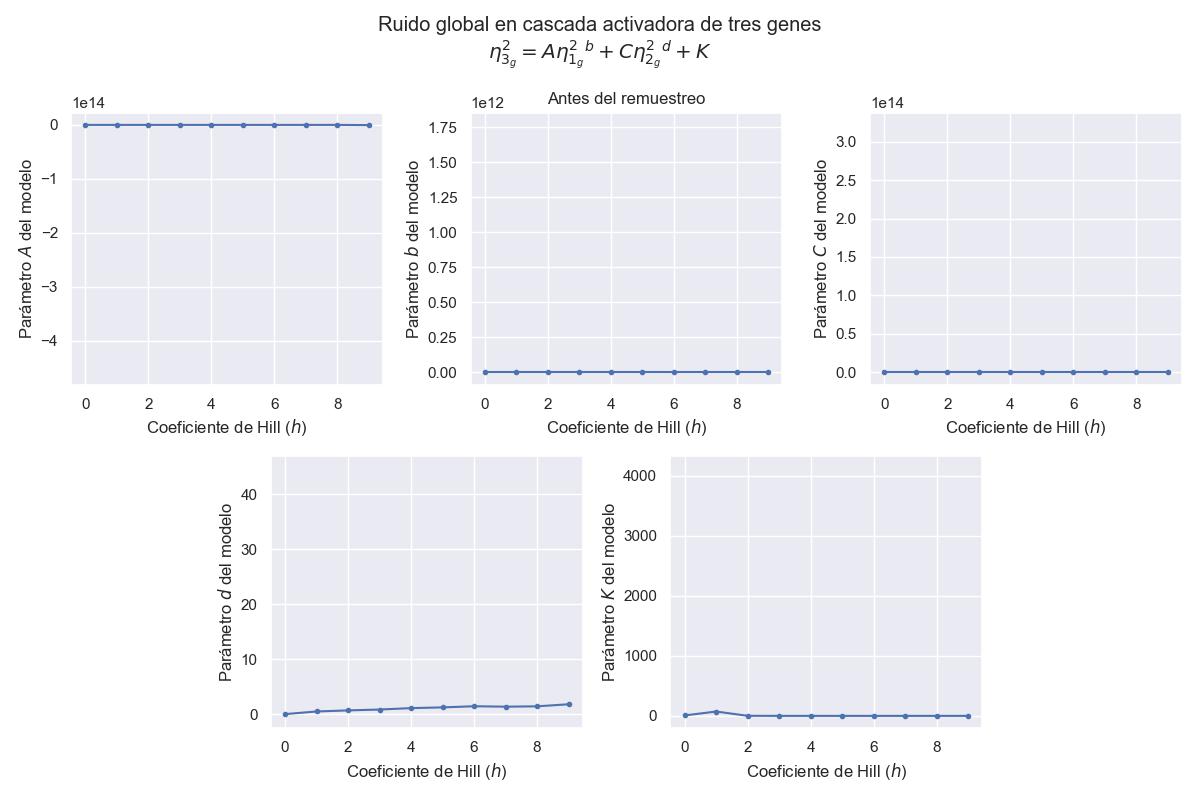

No such comm: e77fbf95ecbd4f2ea4a9e187144c8337


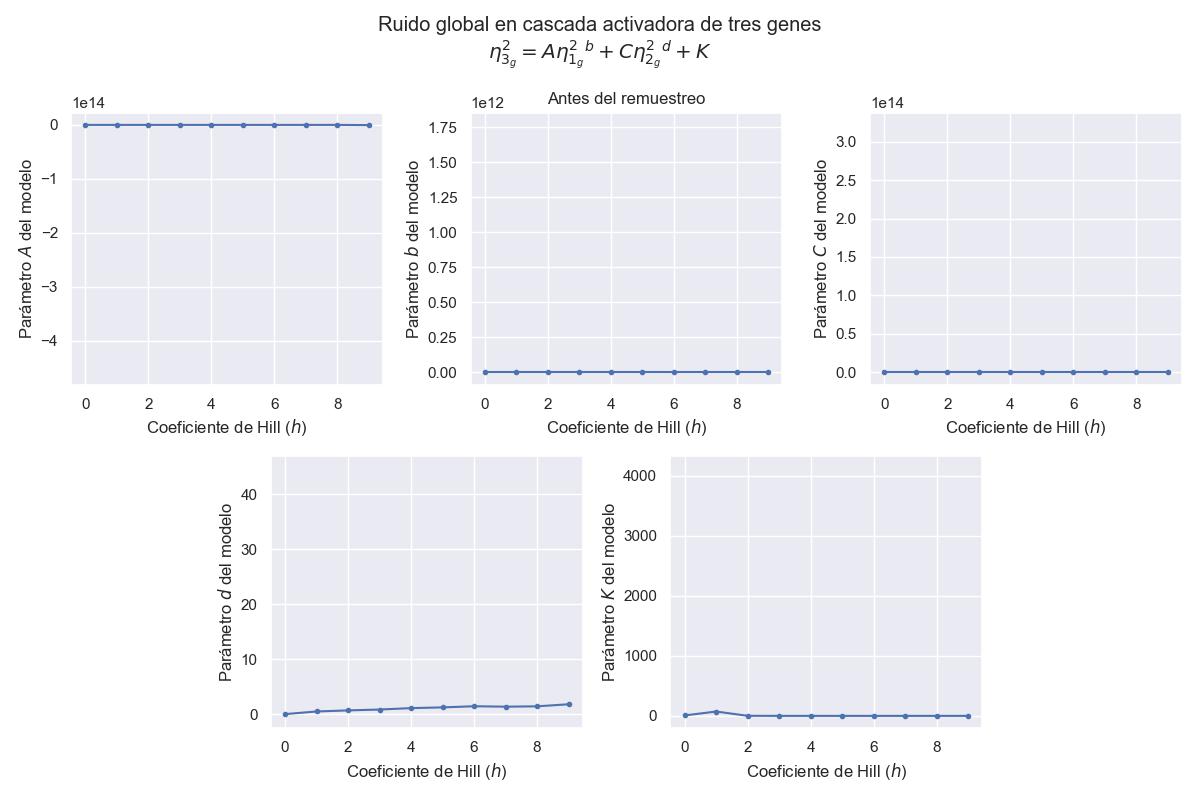

No such comm: d2894719e12748a8899cada1a40853da
No such comm: d2894719e12748a8899cada1a40853da
No such comm: d2894719e12748a8899cada1a40853da
No such comm: d2894719e12748a8899cada1a40853da


In [ ]:
labels = ["A", "b", "C", "d", "K"]
plot_prebootstrap(TresGlobParams, ParamsTensorTresEfc, ErrTensorTresEfc, labels, title="Ruido global en cascada activadora de tres genes"+"\n"+r"$\eta_{3_g}^2=A{\eta_{1_g}^2}^{b}+C{\eta_{2_g}^2}^{d}+K$")

# Export

In [ ]:
seeds_df = pd.read_csv("ActivatorsDefinitiveSeeds.csv", index_col=0)
seeds_df["3 genes"] = [def_seed_int, def_seed_net]
seeds_df.to_csv("ActivatorsDefinitiveSeeds.csv")

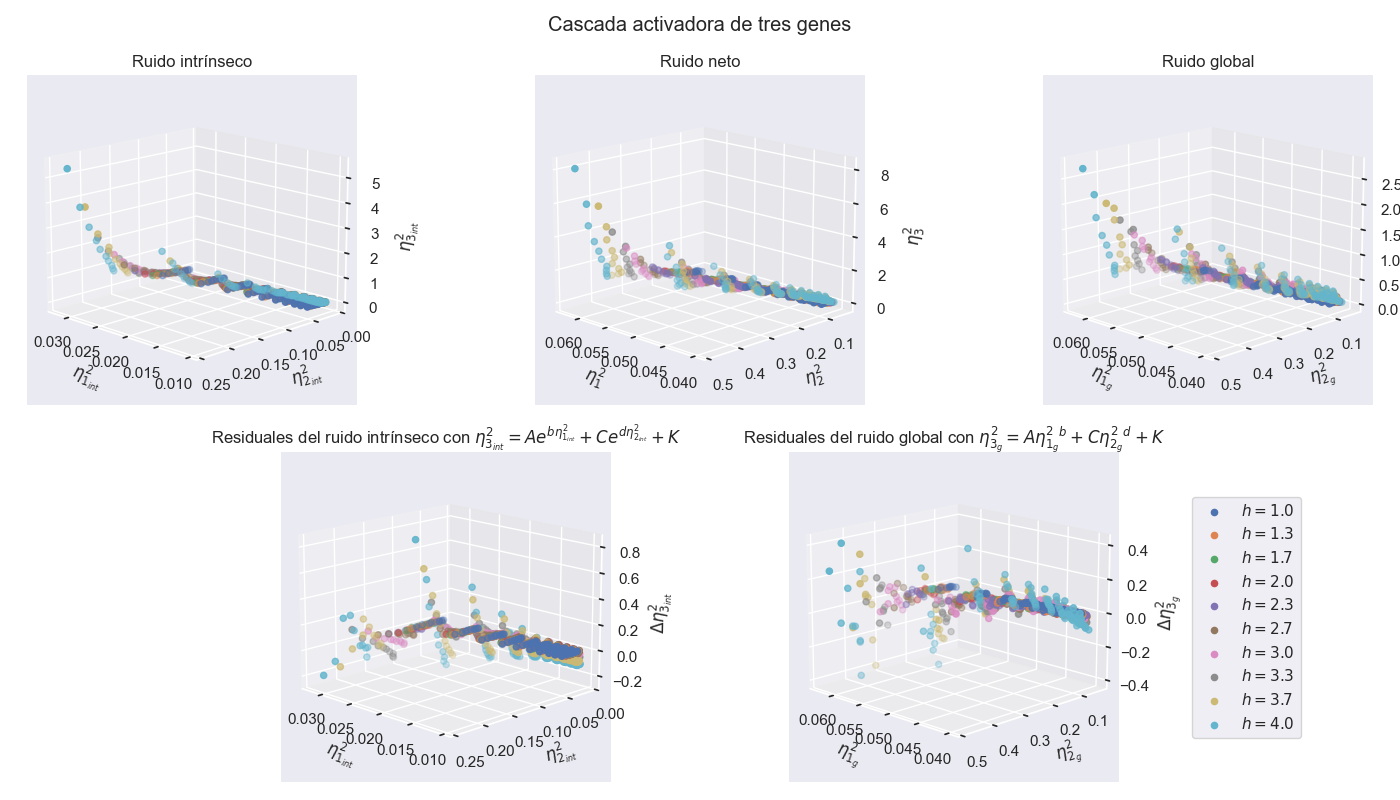

In [ ]:
plt.figure(figsize=(14,8))

ax = plt.subplot2grid((2,6), (0,0), colspan=2, projection="3d")
for h_i in h_list:
    noise1 = tres_int.loc[tres_int.h==h_i]["Protein 1"]
    noise2 = tres_int.loc[tres_int.h==h_i]["Protein 2"]
    noise3 = tres_int.loc[tres_int.h==h_i]["Protein 3"]
    
    ax.scatter(noise1, noise2, noise3, label=fr"$h={h_i:.2}$")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.view_init(elev=15, azim=135, roll=0)
    ax.set_xlabel(r"$\eta_{1_{int}}^2$")
    ax.set_ylabel(r"$\eta_{2_{int}}^2$")
    ax.set_zlabel(r"$\eta_{3_{int}}^2$")
    ax.set_title("Ruido intrínseco")

ax = plt.subplot2grid((2,6), (0,2), colspan=2, projection="3d")
for h_i in h_list:
    noise1 = tres_net.loc[tres_net.h==h_i]["Protein 1"]
    noise2 = tres_net.loc[tres_net.h==h_i]["Protein 2"]
    noise3 = tres_net.loc[tres_net.h==h_i]["Protein 3"]
    
    ax.scatter(noise1, noise2, noise3, label=fr"$h={h_i:.2}$")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.view_init(elev=15, azim=135, roll=0)
    ax.set_xlabel(r"$\eta_1^2$")
    ax.set_ylabel(r"$\eta_2^2$")
    ax.set_zlabel(r"$\eta_3^2$")
    ax.set_title("Ruido neto")

ax = plt.subplot2grid((2,6), (0,4), colspan=2, projection="3d")
for h_i in h_list:
    noise1 = tres_efc.loc[tres_efc.h==h_i]["Protein 1"]
    noise2 = tres_efc.loc[tres_efc.h==h_i]["Protein 2"]
    noise3 = tres_efc.loc[tres_efc.h==h_i]["Protein 3"]
    
    ax.scatter(noise1, noise2, noise3, label=fr"$h={h_i:.2}$")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.view_init(elev=15, azim=135, roll=0)
    ax.set_xlabel(r"$\eta_{1_g}^2$")
    ax.set_ylabel(r"$\eta_{2_g}^2$")
    ax.set_zlabel(r"$\eta_{3_g}^2$")
    ax.set_title("Ruido global")

ax = plt.subplot2grid((2,6), (1,1), colspan=2, projection="3d")
def model(data, A, b, C, d, K):
    x, y = data
    return A*np.exp(b*x) + C*np.exp(d*y) + K
for i in range(len(h_list)):
    noise1 = tres_int.loc[tres_int.h==h_list[i]]["Protein 1"]
    noise2 = tres_int.loc[tres_int.h==h_list[i]]["Protein 2"]
    noise3 = tres_int.loc[tres_int.h==h_list[i]]["Protein 3"]
    
    ax.scatter(noise1, noise2, noise3-model([noise1, noise2], *(TresIntParams[i])), label=fr"$h={h_list[i]:.2}$")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.view_init(elev=15, azim=135, roll=0)
    ax.set_xlabel(r"$\eta_{1_{int}}^2$")
    ax.set_ylabel(r"$\eta_{2_{int}}^2$")
    ax.set_zlabel(r"$\Delta \eta_{3_{int}}^2$")
    ax.set_title(r"Residuales del ruido intrínseco con $\eta_{3_{int}}^2=Ae^{b\eta_{1_{int}}^2}+Ce^{d\eta_{2_{int}}^2}+K$")

ax = plt.subplot2grid((2,6), (1,3), colspan=2, projection="3d")
def model(data, A, b, C, d, K):
    x, y = data
    return A*(x**b) + C*(y**d) + K
for i in range(len(h_list)):
    noise1 = tres_efc.loc[tres_efc.h==h_list[i]]["Protein 1"]
    noise2 = tres_efc.loc[tres_efc.h==h_list[i]]["Protein 2"]
    noise3 = tres_efc.loc[tres_efc.h==h_list[i]]["Protein 3"]
    
    ax.scatter(noise1, noise2, noise3-model([noise1, noise2], *(TresGlobParams[i])), label=fr"$h={h_list[i]:.2}$")
    ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
    ax.view_init(elev=15, azim=135, roll=0)
    ax.set_xlabel(r"$\eta_{1_g}^2$")
    ax.set_ylabel(r"$\eta_{2_g}^2$")
    ax.set_zlabel(r"$\Delta \eta_{3_g}^2$")
    ax.set_title(r"Residuales del ruido global con $\eta_{3_g}^2=A{\eta_{1_g}^2}^{b}+C{\eta_{2_g}^2}^{d}+K$")

plt.suptitle("Cascada activadora de tres genes")
plt.tight_layout()
plt.savefig("GraficasParaGuardar/Simulacion/CascadaActivadoraTres.png", dpi=1000)